In [157]:
import numpy as np
import pylab as plt
from tqdm import tqdm

https://github.com/erikdelange/Reinforcement-Learning-Maze/blob/master/models/qtable.py

In [2]:
def generate_block_maze(nX=10,nY=10,pb=0.3,annotate=False):
    """
    nX,nY - maze dimensions
    p: probability of wall cell
    """
    np.random.seed(20221031)
    lCells = np.meshgrid(np.arange(nX),np.arange(nY))
    lCells0r = np.ravel(lCells[0])
    lCells1r = np.ravel(lCells[1])
    
    # 1: available, 0: blocked
    lFilledCells = np.random.choice([1,0],len(lCells0r),p=[1-pb,pb])
    
    d_color = {1:'none',0:'black'}
    
    plt.figure(figsize=(10,10))
    plt.xlim(-1,nX)
    plt.ylim(-1,nY)
    plt.scatter(lCells0r,lCells1r,marker='s', facecolor=[d_color[item] for item in lFilledCells], edgecolor='k',s=2400)
    
    if annotate == True:
        for ii in range(len(lCells0r)):
            plt.text(lCells0r[ii],lCells1r[ii],str(ii))
    plt.show()
    
    d_cell2index = {}
    for ii in range(len(lCells0r)):
        d_cell2index[(lCells0r[ii],lCells1r[ii])] = ii

    d_index2cell = {}
    for ii in range(len(lCells0r)):
        d_index2cell[ii] = (lCells0r[ii],lCells1r[ii])
        
    return(d_cell2index,d_index2cell,lFilledCells)

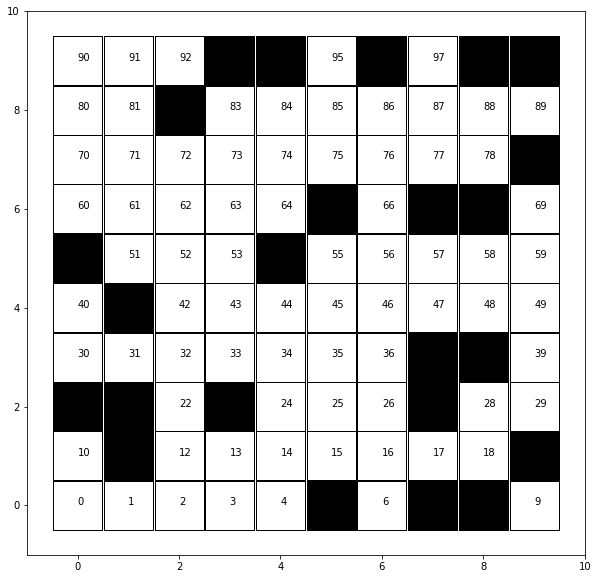

In [3]:
maze_structure = generate_block_maze(nX=10,nY=10,pb=0.3,annotate=True)

In [4]:
# N -> E - > S - > W
d_index2action = {}
d_index2action[0] = (0,1)
d_index2action[1] = (1,0)
d_index2action[2] = (0,-1)
d_index2action[3] = (-1,0)

d_action2index = {}
d_action2index[(0,1)] = 0
d_action2index[(1,0)] = 1
d_action2index[(0,-1)] = 2
d_action2index[(-1,0)] = 3

In [5]:
def get_possible_actions_with_rewards(cell_index,maze_structure,l_path,exit_cell_index):

    reward_exit = 10.0  # reward for reaching the exit cell
    penalty_move = -0.05  # penalty for a move which did not result in finding the exit cell
    penalty_visited = -0.25  # penalty for returning to a cell which was visited earlier
    penalty_impossible_move = -0.75  # penalty for trying to enter an occupied cell or moving out of the maze
    
    
    d_cell2index,d_index2cell,lFilledCells = maze_structure
    #print(d_index2cell[cell_index])
    if lFilledCells[cell_index]==0:
        #print("Filled Cell")
        return(['Nope-FilledCell'])
    else:
        l_possible_cell_index = []
        l_possible_rewards = []
        for ii in d_index2action.keys():
            new_cell = np.array(d_index2action[ii]) + np.array(d_index2cell[cell_index])
            if tuple(new_cell) in d_cell2index.keys():
                new_cell_index = d_cell2index[tuple(new_cell)]
                l_possible_cell_index.append(new_cell_index)
                if new_cell_index == exit_cell_index:
                    l_possible_rewards.append(reward_exit)
                elif new_cell_index in l_path:
                    l_possible_rewards.append(penalty_visited)
                elif lFilledCells[new_cell_index]==0:
                    l_possible_rewards.append(penalty_impossible_move)
                else:
                    l_possible_rewards.append(penalty_move)
            else:
                l_possible_cell_index.append(-1)
                l_possible_rewards.append(penalty_impossible_move)

    return([l_possible_cell_index,l_possible_rewards])


In [41]:
get_possible_actions_with_rewards(9,maze_structure,l_path=[45],exit_cell_index=69)

[[19, -1, -1, 8], [-0.75, -0.75, -0.75, -0.75]]

In [12]:
lFilledCells[0]

1

In [165]:
d_cell2index,d_index2cell,lFilledCells = maze_structure
Q = np.zeros((len(d_cell2index),4))


alpha = 1
gamma = 0.8
lScore = [0]
eps = 0.05

reached_exit = False

l_path = [cell_index]
exit_cell_index = 69
for episode in tqdm(range(1000000)):
    cell_index = np.random.choice(np.arange(len(lFilledCells))[lFilledCells==1])
    #print(episode,cell_index)
    reached_exit = False
    while reached_exit == False:
    #for _ in range(20):
        next_state_structure = get_possible_actions_with_rewards(cell_index,maze_structure,l_path=l_path,exit_cell_index=exit_cell_index)
        if len(next_state_structure)==2:
            [l_possible_next_cell_index,l_possible_rewards] = next_state_structure
            if np.sum(l_possible_rewards) == 4*(-0.75):
                break
        else:
            continue
        #print(l_possible_next_cell_index,l_possible_rewards)
        if np.random.rand() < eps:
            action_index = np.random.choice(np.arange(len(l_possible_next_cell_index))[np.array(l_possible_next_cell_index)>=0])
        else:    
            
            action_index_maxQ_bool = Q[cell_index]==np.max(Q[cell_index])
            action_index_possible_bool = np.array(l_possible_next_cell_index)>=0
            action_index_maxQ_possible = np.arange(len(l_possible_next_cell_index))[action_index_maxQ_bool*action_index_possible_bool]
            if len(action_index_maxQ_possible) >0:
                action_index = np.random.choice(action_index_maxQ_possible)
            else:
                continue
        
        next_cell_index = d_cell2index[tuple(np.array(d_index2cell[cell_index]) + np.array(d_index2action[action_index]))]
        
        if lFilledCells[next_cell_index]==0:
            continue
        else:
        
            reward = l_possible_rewards[action_index]

            max_next_Q = np.max(Q[next_cell_index])

            Q[cell_index,action_index] = Q[cell_index,action_index] + alpha*(reward + gamma*max_next_Q - Q[cell_index,action_index])

            cell_index = next_cell_index
            l_path.append(cell_index)
            #print(l_path)
        if cell_index == exit_cell_index:
            reached_exit == True
            #print(l_path)
            #print('Reached Exit')
            break
        if len(l_path) > len(d_cell2index)*2:
            #print(l_path)
            #print('Path too long')
            break

            #print(l_path)
    #print(Q)


100%|███████████████████████████████| 1000000/1000000 [5:39:13<00:00, 49.13it/s]


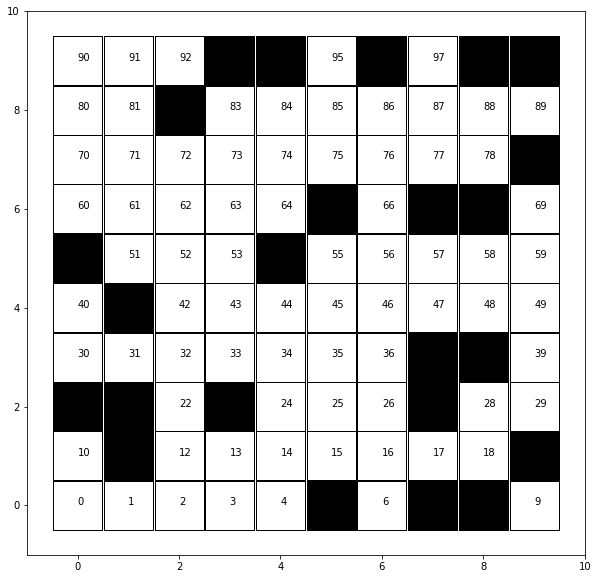

In [48]:
maze_structure = generate_block_maze(nX=10,nY=10,pb=0.3,annotate=True)

In [166]:
Q

array([[-2.50000000e-01,  2.22157608e-03,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  3.15276970e-01,  0.00000000e+00,
        -2.48222739e-01],
       [ 7.06596213e-01,  7.06596213e-01,  0.00000000e+00,
         2.22157608e-03],
       [ 1.19574527e+00,  1.19574527e+00,  0.00000000e+00,
         3.15276970e-01],
       [ 1.80718158e+00,  0.00000000e+00,  0.00000000e+00,
         7.06596213e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.52684622e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.48222739e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
      

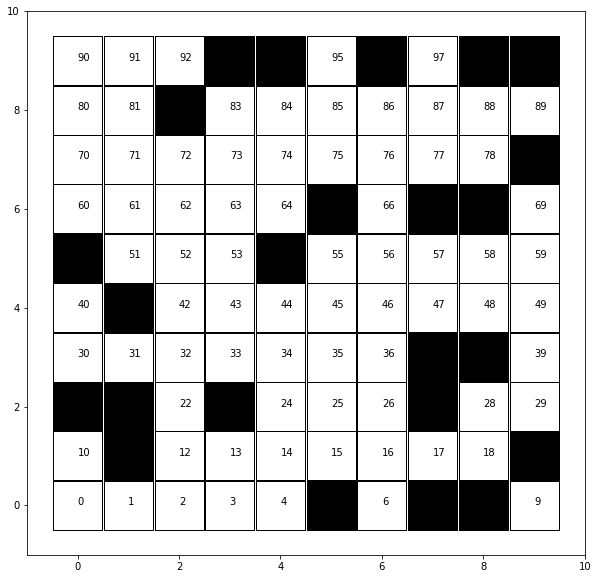

In [39]:
maze_structure = generate_block_maze(nX=10,nY=10,pb=0.3,annotate=True)

In [168]:
cell_index = 10
l_path_final = [cell_index]
while True:
#for _ in range(10):
    action_index = np.random.choice(np.arange(len(Q[cell_index]))[Q[cell_index]==np.max(Q[cell_index])])
    cell_index = d_cell2index[tuple(np.array(d_index2cell[cell_index]) + np.array(d_index2action[action_index]))]
    l_path_final.append(cell_index)
    if cell_index == exit_cell_index:
        print(l_path_final)
        break

[10, 11, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46, 47, 57, 58, 59, 69]


In [169]:
l_path_final

[10, 11, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46, 47, 57, 58, 59, 69]

In [163]:
def travel_block_maze(maze_structure,l_path,annotate=True):
    
    d_cell2index,d_index2cell,lFilledCells = maze_structure
    
    lCells = np.array(list(d_cell2index.keys())).T
    
    print(lCells[1])
        
    d_color = {1:'none',0:'black'}
    
    plt.figure(figsize=(10,10))
    plt.xlim(-1,np.max(lCells[0])+1)
    plt.ylim(-1,np.max(lCells[1])+1)
    plt.scatter(lCells[0],lCells[1],marker='s', facecolor=[d_color[item] for item in lFilledCells], edgecolor='k',s=2400)
    
    if annotate == True:
        for ii in range(len(lCells[0])):
            plt.text(lCells[0][ii],lCells[1][ii],str(ii))
    
    for jj in range(len(l_path)-1):
        path_section = np.array([d_index2cell[l_path[jj]],d_index2cell[l_path[jj+1]]]).T
        plt.plot(path_section[0],path_section[1])
        
    plt.show()

    

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


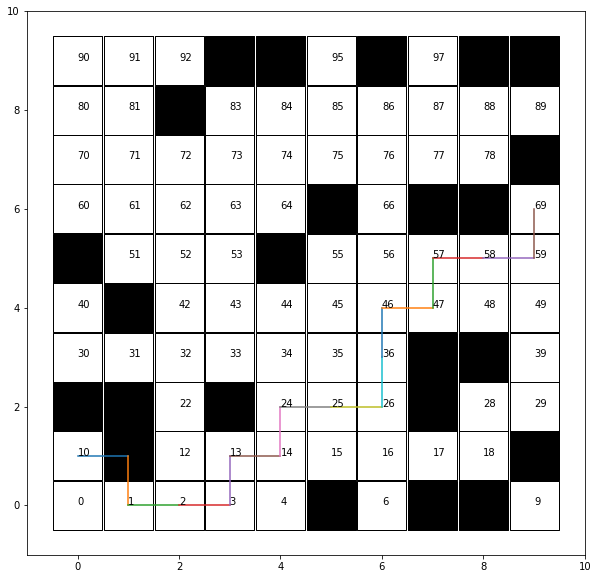

In [170]:
travel_block_maze(maze_structure,l_path_final)

In [172]:
Q_1M = Q

In [256]:
Q = np.zeros((len(d_cell2index),4))

In [257]:
Q[9]

array([0., 0., 0., 0.])

In [258]:
Q[9,:] = [-1,-1,1,1]

In [259]:
Q

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [-1., -1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  

In [260]:
d_cell2index,d_index2cell,lFilledCells = maze_structure
Q = np.zeros((len(d_cell2index),4))


alpha = 1
gamma = 0.8
lScore = [0]
eps = 0.05

reached_exit = False

#l_path = [cell_index]
exit_cell_index = 69
for episode in tqdm(range(1000)):
    #cell_index = np.random.choice(np.arange(len(lFilledCells))[lFilledCells==1])
    cell_index = np.arange(len(lFilledCells))[lFilledCells==1][episode%sum(lFilledCells)]
    #cell_index = 10
    #print(episode,cell_index)
    l_path = [cell_index]
    reached_exit = False
    while reached_exit == False:
    #for _ in range(20):
        next_state_structure = get_possible_actions_with_rewards(cell_index,maze_structure,l_path=l_path,exit_cell_index=exit_cell_index)
        if len(next_state_structure)==2:
            [l_possible_next_cell_index,l_possible_rewards] = next_state_structure
            if np.sum(l_possible_rewards) == 4*(-0.75):
                Q[cell_index,:] = [-np.inf,-np.inf,-np.inf,-np.inf]  
                break
        else:
            continue
        #print(l_possible_next_cell_index,l_possible_rewards)
        if np.random.rand() < eps:
            action_index = np.random.choice(np.arange(len(l_possible_next_cell_index))[np.array(l_possible_next_cell_index)>=0])
        else:    
            
            action_index_maxQ_bool = Q[cell_index]==np.max(Q[cell_index])
            action_index_possible_bool = np.array(l_possible_next_cell_index)>=0
            action_index_maxQ_possible = np.arange(len(l_possible_next_cell_index))[action_index_maxQ_bool*action_index_possible_bool]
            if len(action_index_maxQ_possible) >0:
                action_index = np.random.choice(action_index_maxQ_possible)
            else:
                continue
                
        #if cell_index == 40:
        #    print(cell_index,action_index)
        
        next_cell_index = d_cell2index[tuple(np.array(d_index2cell[cell_index]) + np.array(d_index2action[action_index]))]
        
        if lFilledCells[next_cell_index]==0:
            continue
        else:
        
            reward = l_possible_rewards[action_index]

            max_next_Q = np.max(Q[next_cell_index])

            Q[cell_index,action_index] = Q[cell_index,action_index] + alpha*(reward + gamma*max_next_Q - Q[cell_index,action_index])

            cell_index = next_cell_index
            l_path.append(cell_index)
            #print(l_path)
        if cell_index == exit_cell_index:
            reached_exit == True
            #print(l_path)
            #print('Reached Exit')
            break
        if len(l_path) > len(d_cell2index)*3:
            #print(l_path)
            #print('Path too long')
            break

        #print(l_path)
    #print(Q)


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 145.49it/s]


In [262]:
Q[9]

array([-inf, -inf, -inf, -inf])

In [265]:
Q.sum(axis=1)

array([ 7.24118761e-01,  1.96966346e+00,  2.36860327e+00,  4.34279415e+00,
        1.16025676e+00,  0.00000000e+00,  4.26468140e+00,  0.00000000e+00,
        0.00000000e+00,            -inf,  7.27643859e-01,  0.00000000e+00,
        2.04085696e+00,  5.19996687e+00,  2.73974512e+00,  2.36179610e+00,
        9.18034598e+00,  6.76479244e+00,  1.42966210e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.48857119e+00,  0.00000000e+00,
        7.47133265e+00,  1.42161189e+01,  1.13838322e+01,  0.00000000e+00,
        1.08812724e+01,  2.11807962e+01,  1.89085696e+00,  2.48857119e+00,
        7.05785158e+00,  8.65814442e+00,  1.57539037e+01,  2.01131172e+01,
        2.00543433e+01,  0.00000000e+00,  0.00000000e+00,  2.78906667e+01,
        1.64228079e+00,  0.00000000e+00,  6.56212623e+00,  8.85598630e+00,
        1.13324666e+01,  1.01042646e+01,  2.96110704e+01,  3.67270089e+01,
        4.58569707e+01,  4.93320528e+01,  0.00000000e+00,  2.43680433e+00,
        3.40154252e+00,  

In [268]:
cell_index = 10
l_path_final = [cell_index]
while True and np.sum(Q[cell_index])!=-np.inf:
#for _ in range(10):
    action_index = np.random.choice(np.arange(len(Q[cell_index]))[Q[cell_index]==np.max(Q[cell_index])])
    cell_index = d_cell2index[tuple(np.array(d_index2cell[cell_index]) + np.array(d_index2action[action_index]))]
    l_path_final.append(cell_index)
    if cell_index == exit_cell_index:
        print(l_path_final)
        break

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46, 47, 57, 58, 59, 69]


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


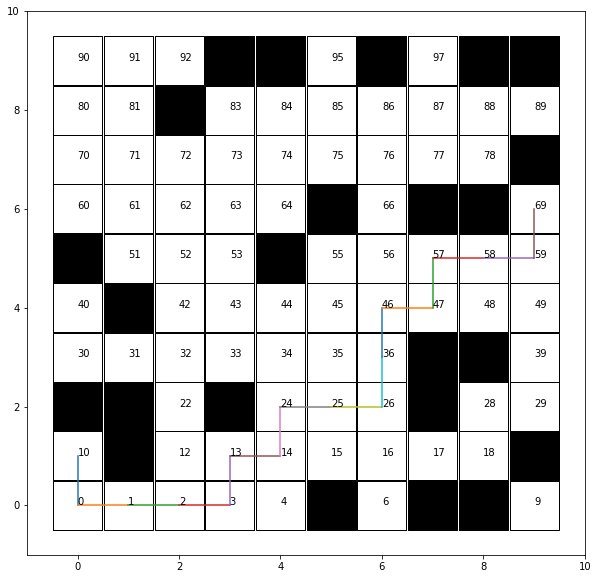

In [269]:
travel_block_maze(maze_structure,l_path_final)

In [248]:
Q[9]

array([0., 0., 0., 0.])

In [270]:
M = np.zeros((len(d_index2cell),len(d_index2cell)))

In [277]:
for ii in range(len(d_index2cell)):
    for jj in range(len(d_index2action)):
        try:
            kk= d_cell2index[tuple(np.array(d_index2cell[ii])+np.array(d_index2action[jj]))]
            M[ii][kk] = Q[ii][jj]
        except:
            pass

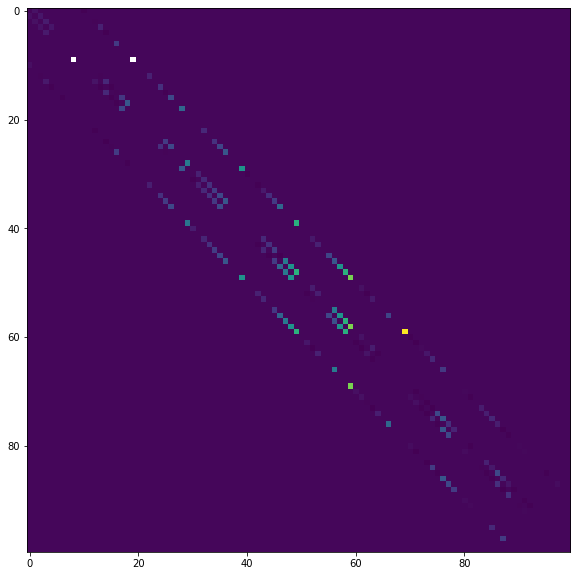

In [278]:
plt.figure(figsize=(10,10))
plt.imshow(M)

In [344]:
def travel_block_maze_Q(maze_structure,l_path_final,i_path,Q, annotate=True):
    
    d_cell2index,d_index2cell,lFilledCells = maze_structure
    
    lCells = np.array(list(d_cell2index.keys())).T
            
    d_color = {1:'none',0:'black'}
    
    plt.figure(figsize=(10,10))
    plt.xlim(-1,np.max(lCells[0])+1)
    plt.ylim(-1,np.max(lCells[1])+1)
    plt.scatter(lCells[0],lCells[1],marker='s', facecolor=[d_color[item] for item in lFilledCells], edgecolor='k',s=2400)
    
    l_path = l_path_final[:i_path]
    print(l_path)
    print(Q[l_path[0]])
    #print(Q)
    
    q_facecolor = np.zeros(len(lCells[0]))
    for ii in range(len(l_path)):
        for jj in d_index2action.keys():
            new_cell = tuple(np.array(d_index2cell[l_path[ii]]) + np.array(d_index2action[jj]))
            if new_cell in d_index2cell.values():
                #print(d_cell2index[new_cell],Q[l_path[ii],jj])
                q_facecolor[d_cell2index[new_cell]] = Q[l_path[ii],jj]
                
    plt.scatter(lCells[0],lCells[1],marker='s', c=q_facecolor/np.sum(q_facecolor),s=2400,alpha=0.5)
 
    
    if annotate == True:
        for ii in range(len(lCells[0])):
            plt.text(lCells[0][ii],lCells[1][ii],str(ii))
    
    for jj in range(len(l_path)-1):
        path_section = np.array([d_index2cell[l_path[jj]],d_index2cell[l_path[jj+1]]]).T
        plt.plot(path_section[0],path_section[1],color='k')
    
    plt.savefig('Maze_Path_' + str(i_path).zfill(3) + '.png')
    plt.show()

[10]
[0.         0.         0.72764386 0.        ]


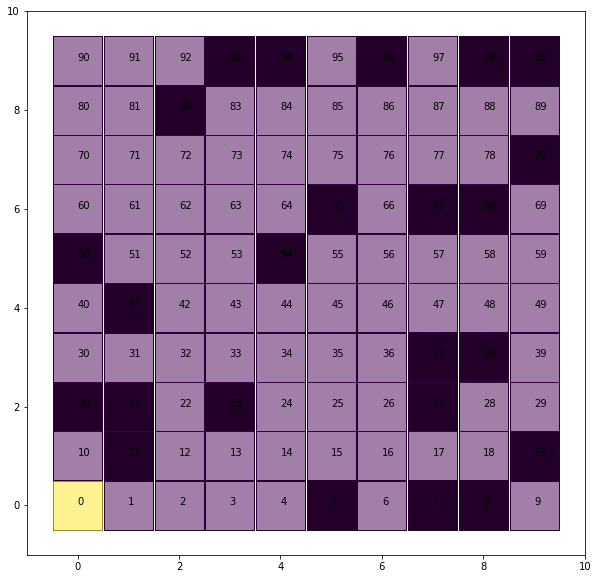

[10, 0]
[0.         0.         0.72764386 0.        ]


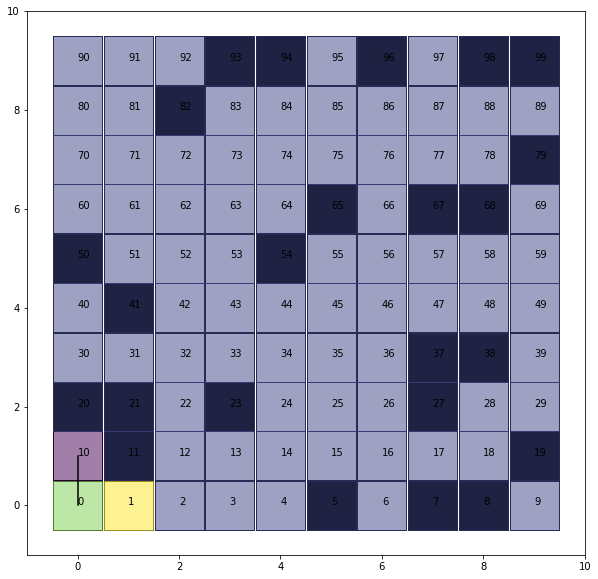

[10, 0, 1]
[0.         0.         0.72764386 0.        ]


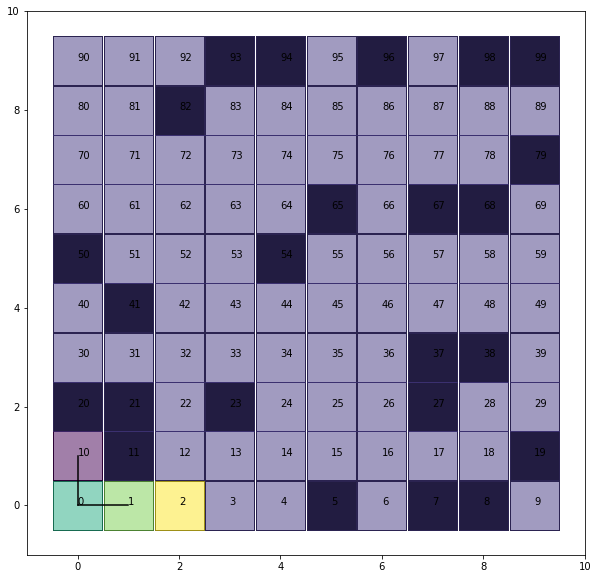

[10, 0, 1, 2]
[0.         0.         0.72764386 0.        ]


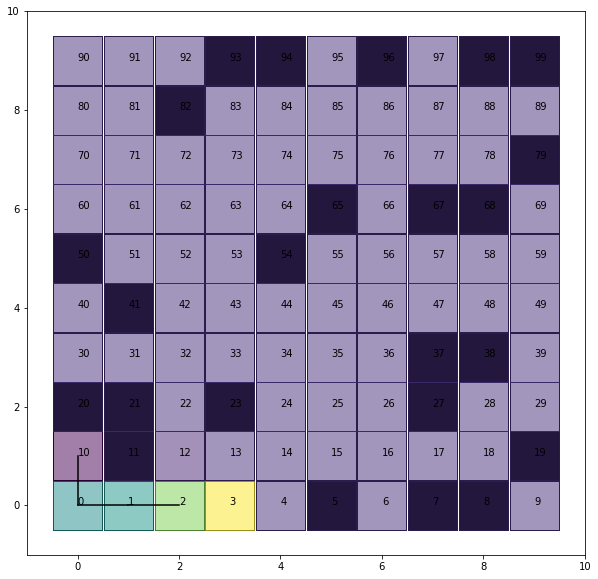

[10, 0, 1, 2, 3]
[0.         0.         0.72764386 0.        ]


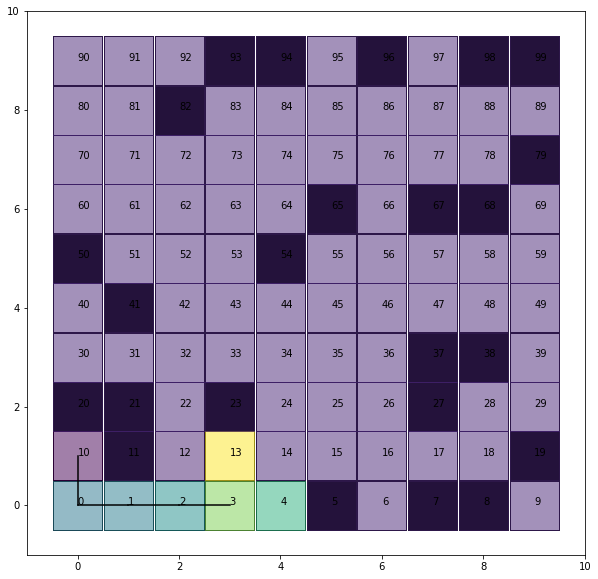

[10, 0, 1, 2, 3, 13]
[0.         0.         0.72764386 0.        ]


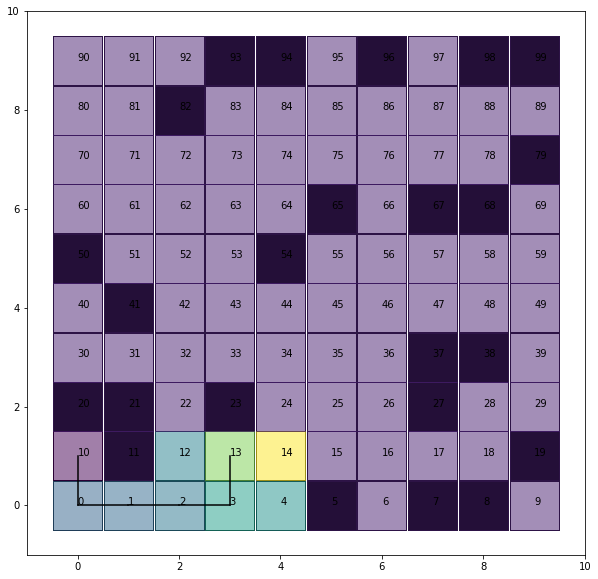

[10, 0, 1, 2, 3, 13, 14]
[0.         0.         0.72764386 0.        ]


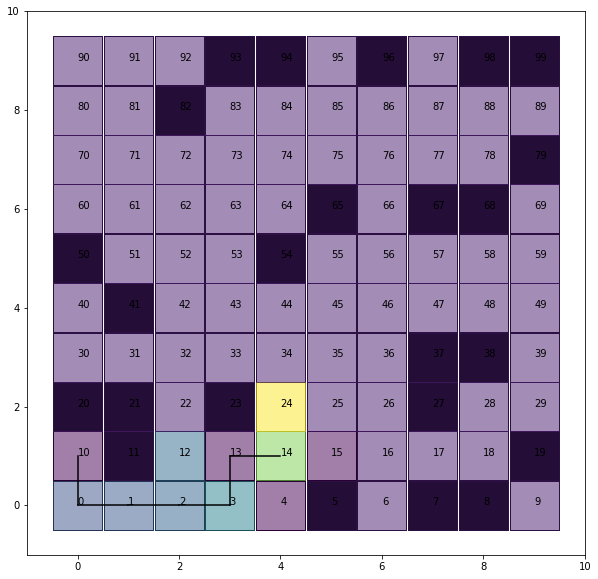

[10, 0, 1, 2, 3, 13, 14, 24]
[0.         0.         0.72764386 0.        ]


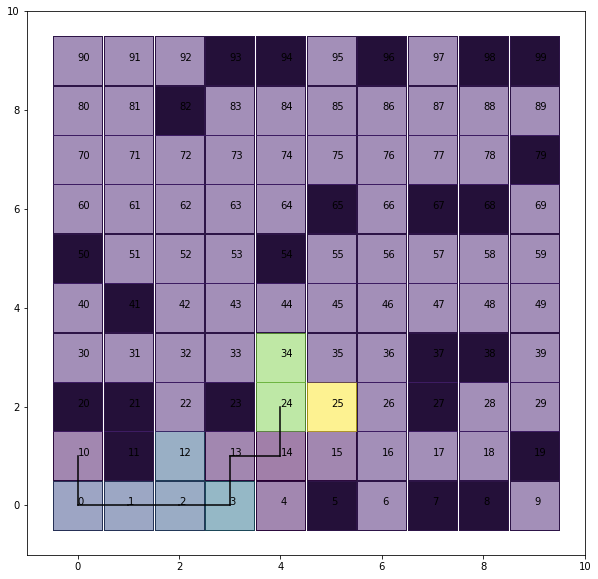

[10, 0, 1, 2, 3, 13, 14, 24, 25]
[0.         0.         0.72764386 0.        ]


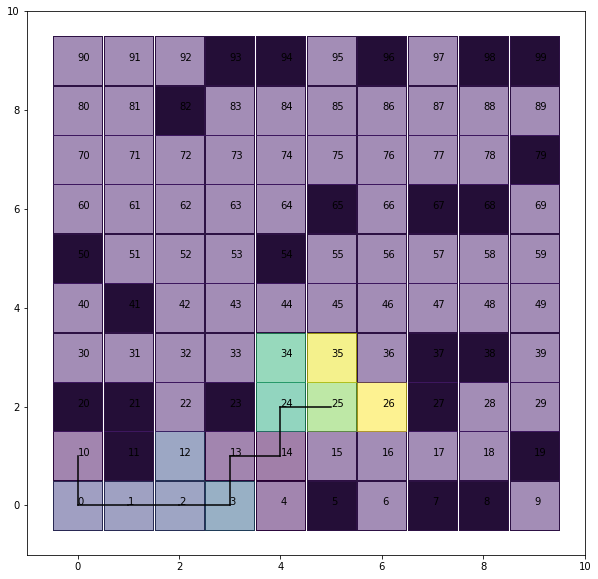

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26]
[0.         0.         0.72764386 0.        ]


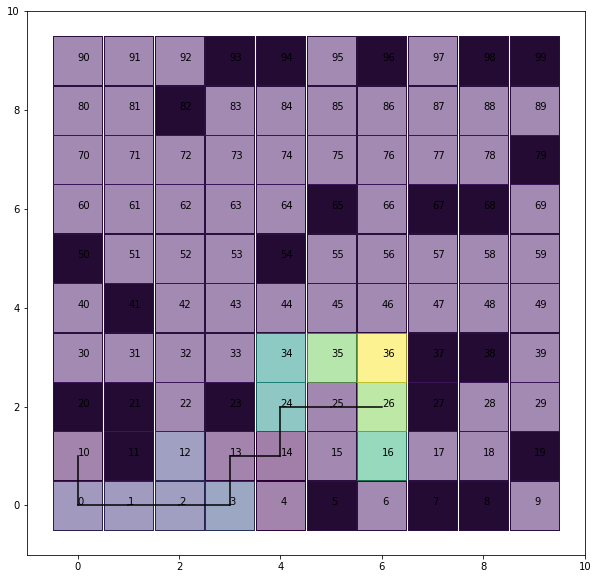

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26, 36]
[0.         0.         0.72764386 0.        ]


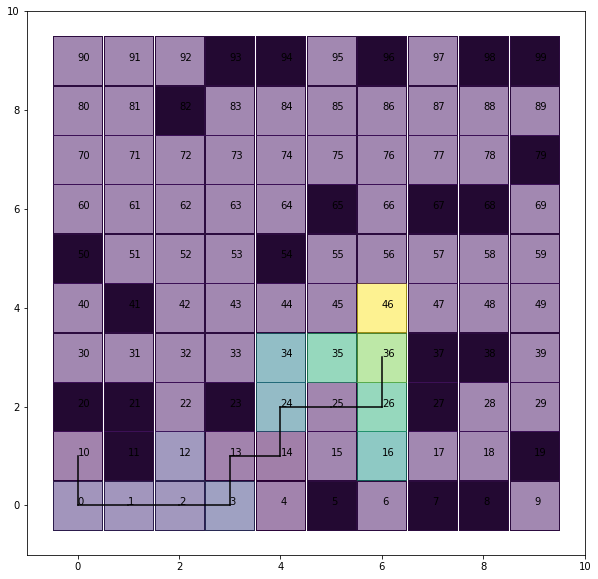

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46]
[0.         0.         0.72764386 0.        ]


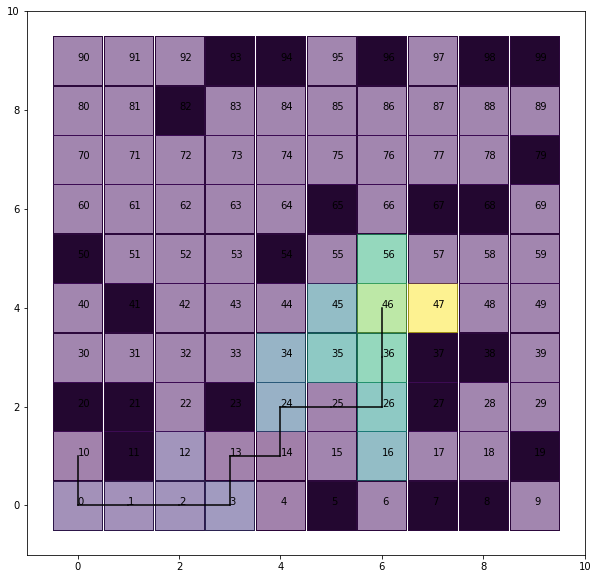

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46, 47]
[0.         0.         0.72764386 0.        ]


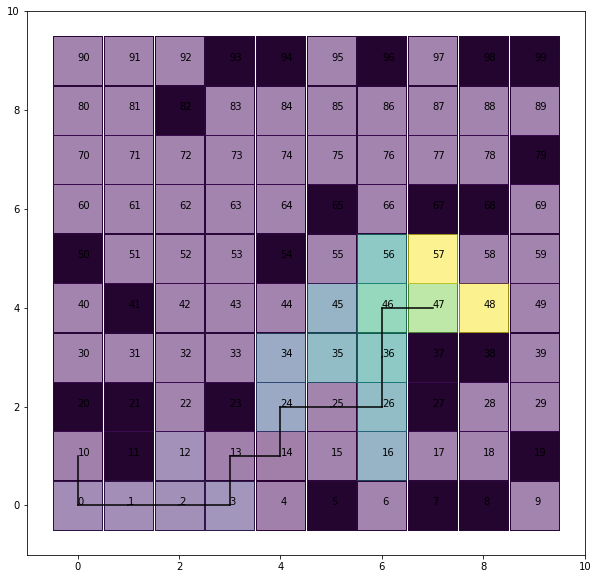

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46, 47, 57]
[0.         0.         0.72764386 0.        ]


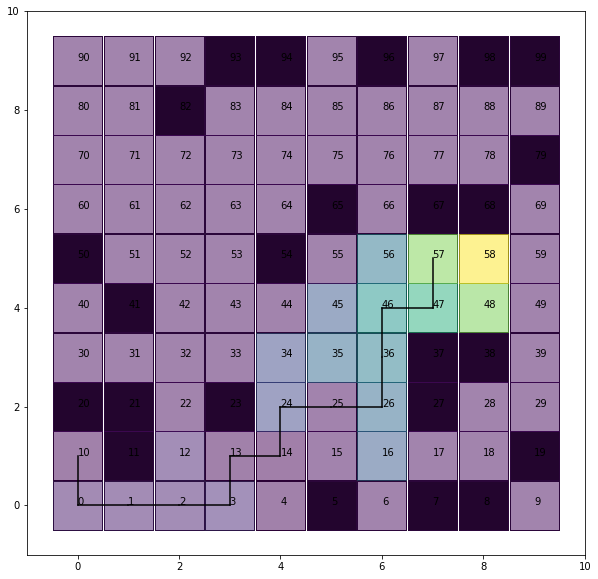

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46, 47, 57, 58]
[0.         0.         0.72764386 0.        ]


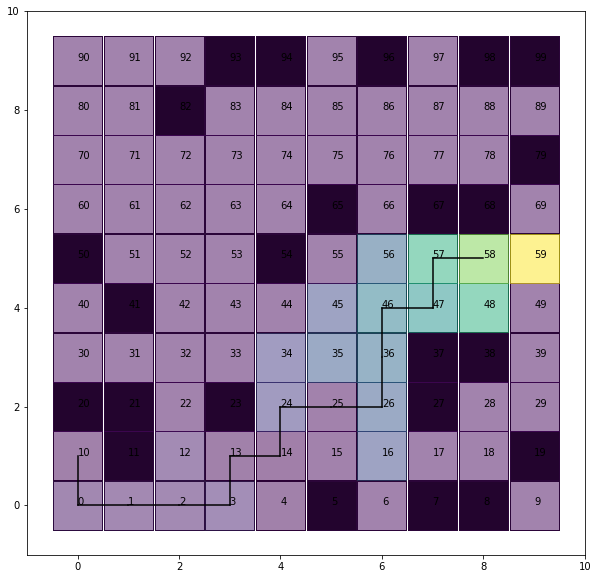

[10, 0, 1, 2, 3, 13, 14, 24, 25, 26, 36, 46, 47, 57, 58, 59]
[0.         0.         0.72764386 0.        ]


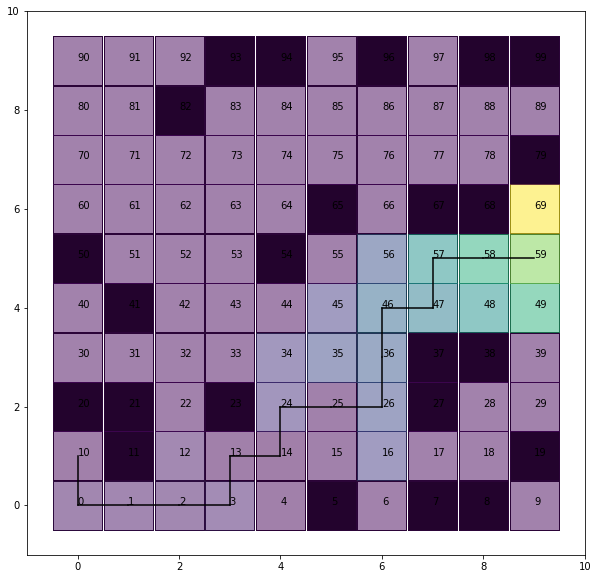

In [345]:
for ii in range(1,len(l_path_final)):
    travel_block_maze_Q(maze_structure,l_path_final,ii,Q)